<a href="https://colab.research.google.com/github/tugcegurbuz/PLENA24-Learning-in-Artificial-Neural-Networks/blob/main/1_MLP_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementing Multi Layer Perceptrons (MLP) with Pytorch

By [Tugce Gurbuz ](https://tugcegurbuz.github.io)as a part of [PLENA-2024](https://plena.cenia.cl) Learning in Artificial Neural Networks workshop

**Reference:** Adapted from [Neuromatch Academy - Deep Learning Summer School](https://deeplearning.neuromatch.io/tutorials/intro.html) - [W1D1 materials](https://deeplearning.neuromatch.io/tutorials/W1D1_BasicsAndPytorch/chapter_title.html)

---
# Tutorial objectives

In this tutorial, we will implement the Multi-layer Perceptrons (MLPs). MLPs are arguably one of the most fundamental and tractable models (due to their flexibility). The main goal for this tutorial is to **gain intuition** about how the machines learn.

---
# Setup

In [26]:
# Imports
import random

import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
from tqdm.auto import tqdm
from IPython.display import display
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# @title Figure settings
import ipywidgets as widgets       # Interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

In [3]:
# @title Plotting functions

def imshow(img):
  """
  Helper function to plot unnormalised image

  Args:
    img: torch.tensor
      Image to be displayed

  Returns:
    Nothing
  """
  img = img / 2 + 0.5     # Unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.axis(False)
  plt.show()


def plot_function_approximation(x, relu_acts, y_hat):
  """
  Helper function to plot ReLU activations and
  function approximations

  Args:
    x: torch.tensor
      Incoming Data
    relu_acts: torch.tensor
      Computed ReLU activations for each point along the x axis (x)
    y_hat: torch.tensor
      Estimated labels/class predictions
      Weighted sum of ReLU activations for every point along x axis

  Returns:
    Nothing
  """
  fig, axes = plt.subplots(2, 1)

  # Plot ReLU Activations
  axes[0].plot(x, relu_acts.T);
  axes[0].set(xlabel='x',
              ylabel='Activation',
              title='ReLU Activations - Basis Functions')
  labels = [f"ReLU {i + 1}" for i in range(relu_acts.shape[0])]
  axes[0].legend(labels, ncol = 2)

  # Plot Function Approximation
  axes[1].plot(x, torch.sin(x), label='truth')
  axes[1].plot(x, y_hat, label='estimated')
  axes[1].legend()
  axes[1].set(xlabel='x',
              ylabel='y(x)',
              title='Function Approximation')

  plt.tight_layout()
  plt.show()

In [4]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [5]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# Inform the user if the notebook uses GPU or CPU.
# NOTE: This is mostly a GPU free tutorial.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("GPU is not enabled in this notebook. \n"
          "If you want to enable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `GPU` from the dropdown menu")
  else:
    print("GPU is enabled in this notebook. \n"
          "If you want to disable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `None` from the dropdown menu")

  return device

In [6]:
SEED = 42
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 42 has been set.
GPU is not enabled in this notebook. 
If you want to enable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `GPU` from the dropdown menu


---
# Section 1: MLPs in Pytorch

MLPs are fascinating, let's start implementing our first machine learning model right away!

## Coding Exercise 1.1.: Implement a general-purpose MLP architecture in Pytorch
The objective is to design an MLP with these properties:
* Works with any input (1D, 2D, etc.)
* Construct any number of given hidden layers using `nn.Sequential()` and `add_module()` function
* Use the same given activation function (i.e., [Leaky ReLU](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html)) in all hidden layers

**Leaky ReLU** is described by the following mathematical formula:

\begin{align}
\text{LeakyReLU}(x) &= \text{max}(0,x) + \text{negative_slope} \cdot \text{min}(0, x) \\
&=
\left\{
  \begin{array}{ll}
  x & ,\; \text{if} \; x \ge 0 \\
  \text{negative_slope} \cdot x & ,\;  \text{otherwise}
  \end{array}
\right.
\end{align}

In [7]:
class MLP(nn.Module):
  """
  Initialize MLP Network
  """

  def __init__(self, actv, input_feature_num, hidden_unit_nums, output_feature_num):
    """
    Initialize MLP Network parameters

    Args:
      actv: string
        Activation function
      input_feature_num: int
        Number of input features
      hidden_unit_nums: int
        Number of units in the hidden layer
      output_feature_num: int
        Number of output features

    Returns:
      Nothing
    """
    super(MLP, self).__init__()
    self.input_feature_num = input_feature_num # Save the input size for reshaping later
    # Initialize layers of MLP

    in_num = input_feature_num # Initialize the temporary input feature to each layer
    layers = [] #Initialize list to store our layers
    for i in range(len(hidden_unit_nums)): # Loop over layers and create each one

      ####################################################################
      # Fill in missing code below (...),
      # Then remove or comment the line below to test your function
      raise NotImplementedError("Create MLP Layer")
      ####################################################################

      out_num = hidden_unit_nums[i] # Assign the current layer hidden unit from list
      layer = nn.Linear(in_num, out_num) # Use nn.Linear to define the layer
      in_num = ... # Assign next layer input using current layer output

      actv_layer = eval('nn.%s'%actv) # Assign activation function (eval allows us to instantiate object from string)
      layers += [..., ...]

    out_layer = nn.Linear(..., ...) # Create final layer
    layers += [out_layer]
    self.mlp = nn.Sequential(*layers)


  def forward(self, x):
    """
    Simulate forward pass of MLP Network

    Args:
      x: torch.tensor
        Input data

    Returns:
      logits: Instance of MLP
        Forward pass of MLP
    """
    # Reshape inputs to (batch_size, input_feature_num)
    # Just in case the input vector is not 2D, like an image!
    x = x.view(-1, self.input_feature_num)

    logits = self.mlp(x) # Forward pass of MLP
    return logits

input = torch.zeros((100, 2))
## Uncomment below to create network and test it on input
# net = MLP(actv='LeakyReLU(0.1)', input_feature_num=2, hidden_unit_nums=[100, 10, 5], output_feature_num=1).to(DEVICE)
# y = net(input.to(DEVICE))
# print(f'The output shape is {y.shape} for an input of shape {input.shape}')

In [8]:
#@markdown Click for solution
class MLP(nn.Module):
  """
  Initialize MLP Network
  """

  def __init__(self, actv, input_feature_num, hidden_unit_nums, output_feature_num):
    """
    Initialize MLP Network parameters

    Args:
      actv: string
        Activation function
      input_feature_num: int
        Number of input features
      hidden_unit_nums: int
        Number of units in the hidden layer
      output_feature_num: int
        Number of output features

    Returns:
      Nothing
    """
    super(MLP, self).__init__()
    self.input_feature_num = input_feature_num # Save the input size for reshaping later
    # Initialize layers of MLP

    in_num = input_feature_num # Initialize the temporary input feature to each layer
    layers = [] #Initialize list to store our layers
    for i in range(len(hidden_unit_nums)): # Loop over layers and create each one

      ####################################################################
      # Fill in missing code below (...),
      # Then remove or comment the line below to test your function
      #raise NotImplementedError("Create MLP Layer")
      ####################################################################

      out_num = hidden_unit_nums[i] # Assign the current layer hidden unit from list
      layer = nn.Linear(in_num, out_num) # Use nn.Linear to define the layer
      in_num = out_num # Assign next layer input using current layer output

      actv_layer = eval('nn.%s'%actv) # Assign activation function (eval allows us to instantiate object from string)
      layers += [layer, actv_layer]

    out_layer = nn.Linear(in_num, output_feature_num) # Create final layer
    layers += [out_layer]
    self.mlp = nn.Sequential(*layers)


  def forward(self, x):
    """
    Simulate forward pass of MLP Network

    Args:
      x: torch.tensor
        Input data

    Returns:
      logits: Instance of MLP
        Forward pass of MLP
    """
    # Reshape inputs to (batch_size, input_feature_num)
    # Just in case the input vector is not 2D, like an image!
    x = x.view(-1, self.input_feature_num)

    logits = self.mlp(x) # Forward pass of MLP
    return logits
input = torch.zeros((100, 2))
## Uncomment below to create network and test it on input
net = MLP(actv='LeakyReLU(0.1)', input_feature_num=2, hidden_unit_nums=[100, 10, 5], output_feature_num=1).to(DEVICE)
y = net(input.to(DEVICE))
print(f'The output shape is {y.shape} for an input of shape {input.shape}')

The output shape is torch.Size([100, 1]) for an input of shape torch.Size([100, 2])


# Section 2: Training an MLP for image classification (hand-written digits)

Check this cool website to see a visualization for our task:
https://ml4a.github.io/demos/forward_pass_mnist/

## Section 2.1: Data

We will use the MNIST dataset of handwritten digits. We load the data via the Pytorch `datasets` module.

**Note:** Although we can download the MNIST dataset directly from `datasets` using the optional argument `download=True`, we are going to download them from NMA directory on OSF to ensure network reliability.


In [16]:
def load_mnist_data(change_tensors=False, download=False):
  """
  Load training and test examples for the MNIST handwritten digits dataset
  with every image: 28*28 x 1 channel (greyscale image)

  Args:
    change_tensors: Bool
      Argument to check if tensors need to be normalised
    download: Bool
      Argument to check if dataset needs to be downloaded/already exists

  Returns:
    train_set:
      train_data: Tensor
        training input tensor of size (train_size x 784)
      train_target: Tensor
        training 0-9 integer label tensor of size (train_size)
    test_set:
      test_data: Tensor
        test input tensor of size (test_size x 784)
      test_target: Tensor
        training 0-9 integer label tensor of size (test_size)
  """
  # Load train and test sets
  train_set = torchvision.datasets.MNIST(root='.', train=True, download=download,
                             transform=torchvision.transforms.ToTensor())
  test_set = torchvision.datasets.MNIST(root='.', train=False, download=download,
                            transform=torchvision.transforms.ToTensor())

  # Original data is in range [0, 255]. We normalize the data wrt its mean and std_dev.
  # Note that we only used *training set* information to compute mean and std
  mean = train_set.data.float().mean()
  std = train_set.data.float().std()

  if change_tensors:
    # Apply normalization directly to the tensors containing the dataset
    train_set.data = (train_set.data.float() - mean) / std
    test_set.data = (test_set.data.float() - mean) / std
  else:
    tform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize(mean=[mean / 255.], std=[std / 255.])
                                            ])
    train_set = torchvision.datasets.MNIST(root='.', train=True, download=download,
                               transform=tform)
    test_set = torchvision.datasets.MNIST(root='.', train=False, download=download,
                              transform=tform)

  return train_set, test_set


train_set, test_set = load_mnist_data(change_tensors=True)

As we are just getting started, we will concentrate on a small subset of only 500 examples out of the 60.000 data points contained in the whole training set.



In [17]:
# Sample a random subset of 500 indices
subset_index = np.random.choice(len(train_set.data), 500)

# We will use these symbols to represent the training data and labels, to stay
# as close to the mathematical expressions as possible.
X, y = train_set.data[subset_index, :], train_set.targets[subset_index]

Run the following cell to visualize the content of three examples in our training set. Note how the preprocessing we applied to the data changes the range of pixel values after normalization.


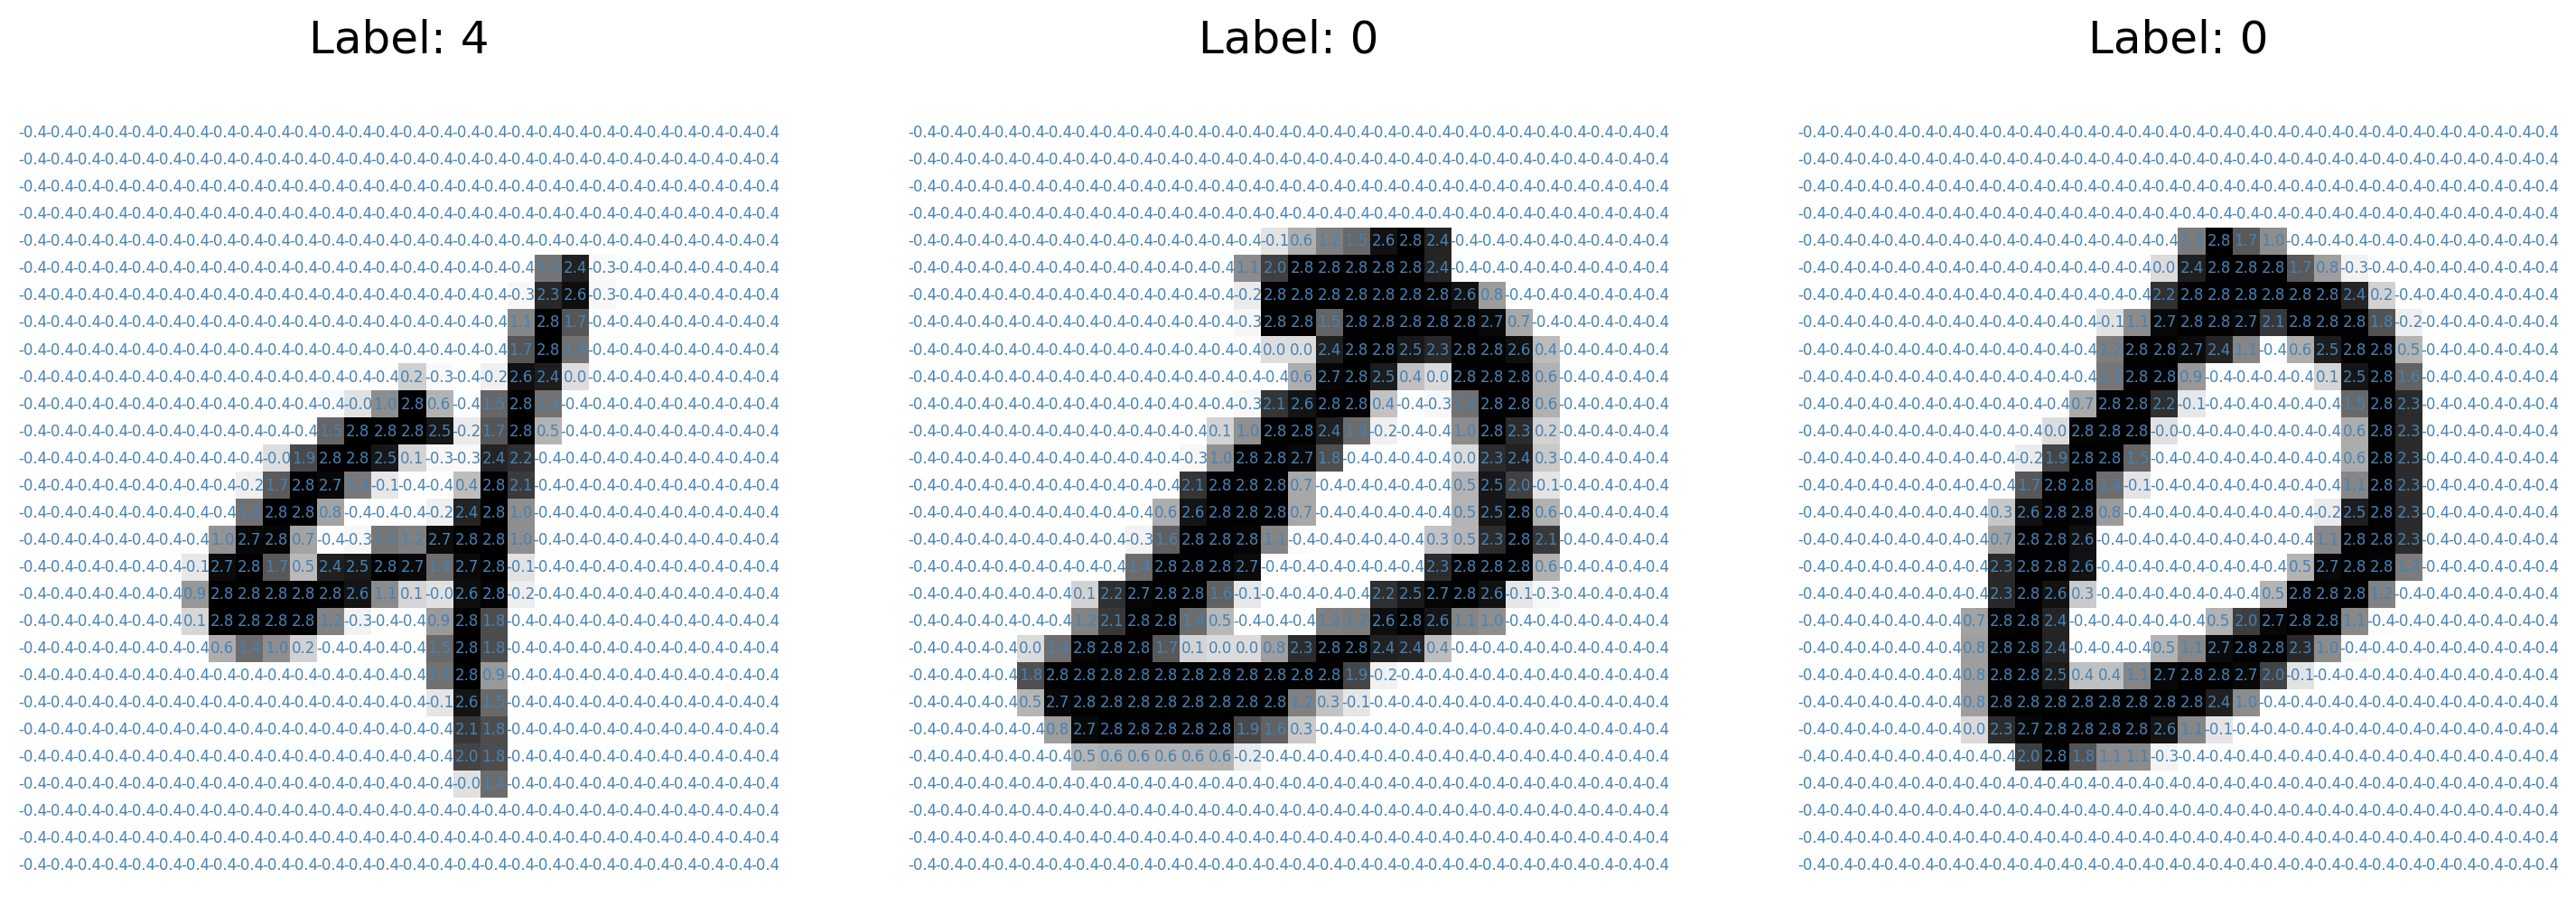

In [18]:
# @title Run me!

# Exploratory data analysis and visualisation

num_figures = 3
fig, axs = plt.subplots(1, num_figures, figsize=(5 * num_figures, 5))

for sample_id, ax in enumerate(axs):
  # Plot the pixel values for each image
  ax.matshow(X[sample_id, :], cmap='gray_r')
  # 'Write' the pixel value in the corresponding location
  for (i, j), z in np.ndenumerate(X[sample_id, :]):
    text = '{:.1f}'.format(z)
    ax.text(j, i, text, ha='center',
            va='center', fontsize=6, c='steelblue')

  ax.set_title('Label: ' + str(y[sample_id].item()))
  ax.axis('off')

plt.show()

## Section 2.2: Model

Let's load the model we created in Section 1.

In [85]:
# Empty hidden_dims means we take a model with zero hidden layers.
model = MLP(input_feature_num=784, output_feature_num=10, hidden_unit_nums=[], actv=None)

# We print the model structure with 784 inputs and 10 outputs
print(model)

MLP(
  (mlp): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=True)
  )
)


## Section 2.3: Loss & Optimizer

We will use the [cross entropy loss (negative log-likelihood)](https://en.wikipedia.org/wiki/Cross-entropy).

This particular choice of model and optimization objective leads to an optimization problem with respect to the parameters $W$ and $b$.

In [86]:
loss_fn = F.nll_loss

In [87]:
optimizer = optim.Adam(model.parameters(), lr=7e-4)

## Section 2.4: Train the model

In [88]:
cell_verbose = True
#partial_trained_model = MLP(in_dim=784, out_dim=10, hidden_dims=[])

if cell_verbose:
  print('Init loss', loss_fn(model(X), y).item()) # This matches around np.log(10 = # of classes)

# Invoke an optimizer using Adaptive gradient and Momentum (more about this in Section 7)
loss_track = []
for _ in range(200):
  loss = loss_fn(model(X), y)
  loss_track.append(loss.detach())
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

if cell_verbose:
  print('End loss', loss_fn(model(X), y).item()) # This should be less than 1e-2

Init loss 0.049427956342697144
End loss -58.47311019897461


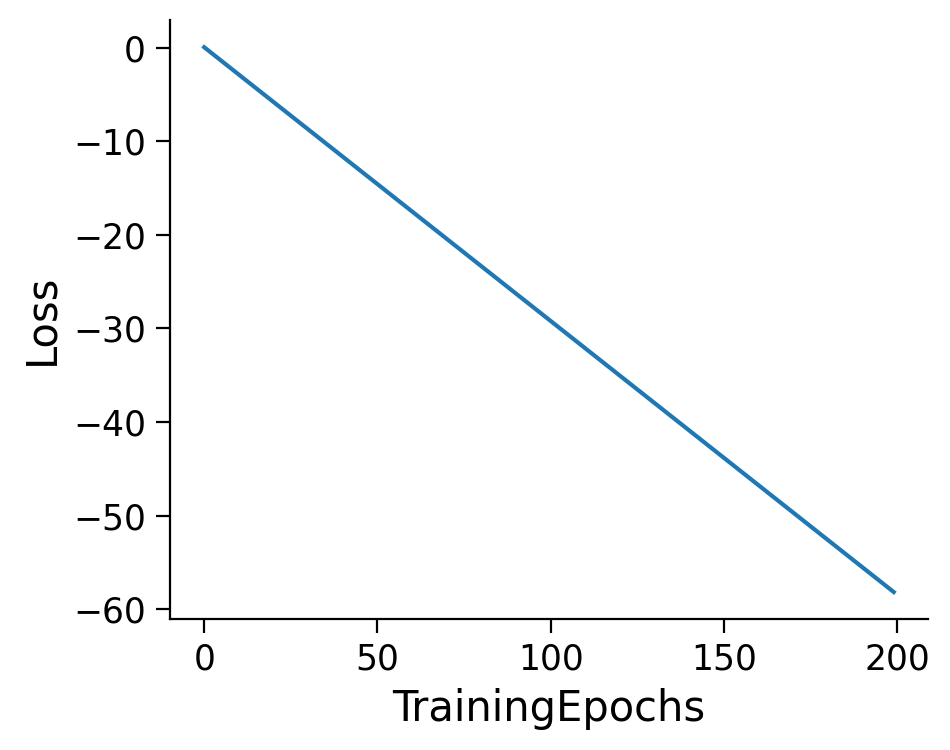

In [89]:
fig, axs = plt.subplots(1, 1, figsize=(5, 4))

axs.set_ylabel('Loss')
axs.set_xlabel('TrainingEpochs')
axs.plot(loss_track)

## Section 2.5: Interpretability -- What does the model learn?

Inspecting the weights of a model can provide insights on what 'concepts' the model has learned. Here we show the weights of a partially trained model. The weights corresponding to each class 'learn' to _fire_ when an input of the class is detected.


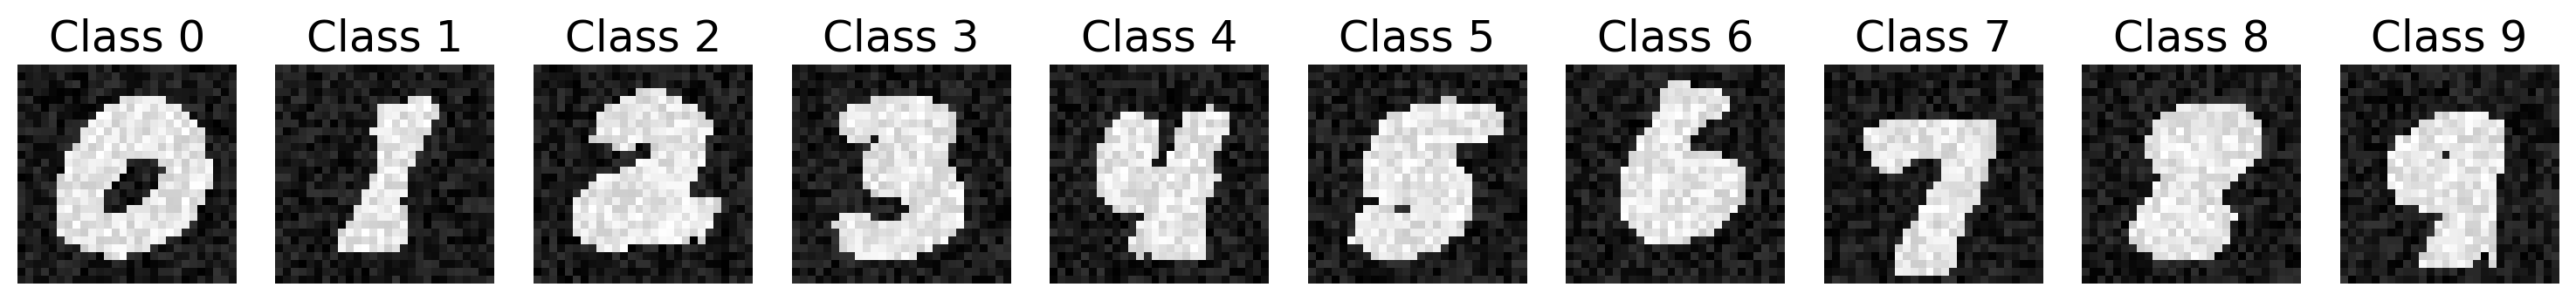

In [90]:
# Show class filters of a trained model
W = list(model.parameters())[0].detach().numpy()

fig, axs = plt.subplots(1, 10, figsize=(15, 4))
for class_id in range(10):
  axs[class_id].imshow(W[class_id, :].reshape(28, 28), cmap='gray')
  axs[class_id].axis('off')
  axs[class_id].set_title('Class ' + str(class_id) )

plt.show()